# Training and Testing Code for Single-Task RBF Kernel

Guidance for Reproducting Results:


1.   **Training Model**: Run all cells between beginning and "Main Training Cell". Set up configuration for the Main training cell: Choose number of iterations and initialisation. Set the correct path for saving check points for the model
2.   **Load Trained Model**: Run all cells from beginning and BEFORE "Main Training Cell". Next, start from "Load Saved Model and Make Predictions", modify the file path to the models desired, then run all cells after.



In [ ]:
!pip install gpytorch

In [ ]:
import pandas as pd
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Update path accordingly to your folder where the dataset is
data = pd.read_csv(r'/content/drive/MyDrive/STAT0035/Cleaned_data.csv', index_col = 0)

In [ ]:
data_sub = data[['Date.time',
 'Power.me',
 'Pot.Power.me',
 'Wind.speed.me',
 'Power.factor.cosphi.me',
 'Front.bearing.temp.me',
 'Rear.bearing.temp.me',
 'Stator1.temp.me',
 'Nacelle.ambient.temp.me',
 'Nacelle.temp.me',
 'Transformer.temp.me',
 'Gear.oil.temp.me',
 'Generator.bearing.rear.temp.me',
 'Generator.bearing.front.temp.me',
 'Gear.oil.temp.me.1',
 'Top.box.temp.me',
 'Hub.temp.me',
 'Conv.Amb.temp.me',
 'Rotor.bearing.temp.me',
 'Transformer.cell.temp.me',
 'Motor.axis1.temp.me',
 'Motor.axis2.temp.me',
 'Motor.axis3.temp.me',
 'CPU.temp.me',
 'Rotor.speed.me',
 'Blade.ang.pitch.pos.A.me',
 'Blade.ang.pitch.pos.B.me',
 'Blade.ang.pitch.pos.C.me',
 'Gear.oil.inlet.press.me',
 'Gear.oil.pump.press.me',
 'Drive.train.acceleration.me',
 'Tower.Acceleration.x',
 'Tower.Acceleration.y',
 'turbine',
 'year']]


### Standardise all variables except date-time

In [ ]:
# Remove negative power values
data_sub = data_sub[data_sub['Power.me'] >= 0]

In [ ]:
# Get the list of all columns
all_columns = data_sub.columns.tolist()

# Columns to exclude from scaling
exclude_columns = ['Date.time', 'turbine', 'year']

# Columns to be standardized (input features + output)
columns_to_standardize = [col for col in all_columns if col not in exclude_columns]

# Dictionary to store mean and standard deviation for each column
standardization_parameters = {}

# Standardization
for col in columns_to_standardize:
    mean = data_sub[col].mean()
    std = data_sub[col].std()
    standardization_parameters[col] = {'mean': mean, 'std': std}
    data_sub[col] = (data_sub[col] - mean) / std

### Conduct correlation analysis on data_sub

### Filtering data

In [ ]:
# Filter out Turbine 1
data_turbine_1 = data_sub[data_sub['turbine'] == 1]

### Training with SM Gaussian Processes

In [ ]:
# I use 80% of the smallest values for training. I don't use scikit learn because they would randomise the order.
# num_rows_80_percent = int(0.8 * len(data_windspeed_linear))

# # FOR 1,000 POINTS
# train_df = data_turbine_1.iloc[:80000:80].fillna(0)
# test_df = data_turbine_1.iloc[80000:100000:80].fillna(0)

# # FOR 5,000 POINTS
# train_df = data_turbine_1.iloc[:80000:16].fillna(0)
# test_df = data_turbine_1.iloc[80000:100000:16].fillna(0)

# # FOR 10,000 POINTS
# train_df = data_turbine_1.iloc[:80000:8].fillna(0)
# test_df = data_turbine_1.iloc[80000:100000:8].fillna(0)


# FOR 7,000 POINTS
train_df = data_turbine_1.iloc[:70000:10].fillna(0)
test_df = data_turbine_1.iloc[70000:100000:3].fillna(0)

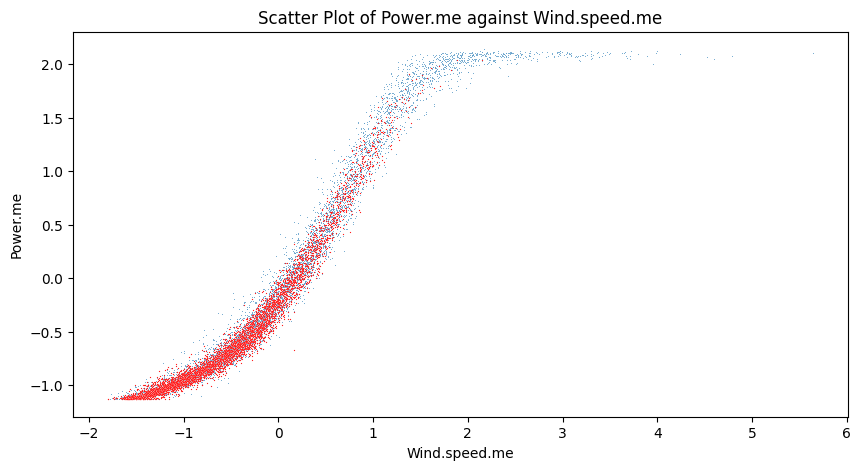

In [ ]:
# Find where the relationship is linear
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Wind.speed.me', y='Power.me', data=train_df, s = 0.5)
sns.scatterplot(x='Wind.speed.me', y='Power.me', data=test_df, s = 0.8, color='red')
plt.title('Scatter Plot of Power.me against Wind.speed.me')
plt.xlabel('Wind.speed.me')
plt.ylabel('Power.me')
plt.show()

In [ ]:
training_var = [
 'Wind.speed.me',
#  'Power.factor.cosphi.me',
#  'Front.bearing.temp.me',
#  'Stator1.temp.me',
#  'Nacelle.ambient.temp.me',
 'Nacelle.temp.me',
#  'Transformer.temp.me',
#  'Gear.oil.temp.me',
#  'Generator.bearing.rear.temp.me',
#  'Generator.bearing.front.temp.me',
#  'Motor.axis1.temp.me',
 'CPU.temp.me',
#  'Rotor.speed.me',
#  'Gear.oil.inlet.press.me',
 'Drive.train.acceleration.me',
 'Tower.Acceleration.x',
#  'Tower.Acceleration.y',
 ]
train_x = torch.tensor(train_df[training_var].values)
train_y = torch.tensor(train_df['Power.me'].values)
test_x = torch.tensor(test_df[training_var].values)
test_y = torch.tensor(test_df['Power.me'].values)

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
# # Function to create a new model and likelihood
# def create_model_and_likelihood(train_x, train_y):
#     likelihood = gpytorch.likelihoods.GaussianLikelihood()
#     model = RBFInducingPointsGPModel(train_x, train_y, likelihood)
#     return model, likelihood

def create_model_and_likelihood(train_x, train_y):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    return model, likelihood

# Function to save the model and likelihood with an initialization identifier
def save_checkpoint(model, likelihood, iteration, init, folder='/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.2.1 - SM vs RBF/Final Results - RBF - 7k'):
    os.makedirs(folder, exist_ok=True)
    torch.save(model.state_dict(), f'{folder}/model_state_init{init}_iter{iteration}.pth')
    torch.save(likelihood.state_dict(), f'{folder}/likelihood_state_init{init}_iter{iteration}.pth')

### Main Training Cell
*  We can skip this cell if we want to load saved model
*  Parameters to we aware of:


1.   Range of initialisation (if the training breaks at 4, insert 4 in the range)
2.   Learning rate
3. Iterations until Save Checkpoints





In [ ]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 1000
n_initializations = 10 # Number of initializations
best_loss = float('inf')
best_model = None
best_likelihood = None

# Training loop for multiple initializations
for init in range(1,n_initializations+1):
    model, likelihood = create_model_and_likelihood(train_x, train_y)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    with tqdm(total=training_iter, desc=f"Training Progress (Init {init})") as pbar:
        for i in range(training_iter):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

            if (i + 1) % 50 == 0:
                save_checkpoint(model, likelihood, i + 1, init)  # Save checkpoint every 500 iterations for each init

    # Compare and store the best model
    final_loss = loss.item()
    if final_loss < best_loss:
        best_loss = final_loss
        best_model = model
        best_likelihood = likelihood

# Save the best model and likelihood
save_checkpoint(best_model, best_likelihood, 'final', 'best')

print(f'Best Loss: {best_loss}')

### Load saved models and make prediction

* We need to re-run the create_model_and_likelihood again because the previous step was done in a function, thus it's local
* Need to run the previous functions for this part onwards, not the Main Training Cell

In [ ]:
model, likelihood = create_model_and_likelihood(train_x, train_y)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [ ]:
# Load saved model and likelihood
model.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.2.1 - SM vs RBF/Final Results - RBF - 7k/model_state_init10_iter1000.pth'))
likelihood.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.2.1 - SM vs RBF/Final Results - RBF - 7k/likelihood_state_init10_iter1000.pth'))

<All keys matched successfully>

In [ ]:
# Calculate loss if necessary. Note that this cell shouldn't be run twice because it will explode
# -mll(model(train_x), train_y)

### Making Prediction

Changing hyperparameters back to float64 is important for gpytorch.settings.fast_pred_var()

In [ ]:
model = model.to(torch.float64)
likelihood = likelihood.to(torch.float64)

In [ ]:
# Your existing training code here

# Make predictions on training data for confidence interval
model.eval()
likelihood.eval()

# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     train_observed_pred = likelihood(model(train_x))
#     train_lower, train_upper = train_observed_pred.confidence_region()
#     train_mean = train_observed_pred.mean.detach().numpy()
#     train_variance = train_observed_pred.variance.detach().numpy()

# Make predictions on test data
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_observed_pred = likelihood(model(test_x))
    test_lower, test_upper = test_observed_pred.confidence_region()
    test_mean = test_observed_pred.mean.detach().numpy()
    test_variance = test_observed_pred.variance.detach().numpy()

### Rescale Power.me to before standardisation

In [ ]:
# Rescale the predictions and related metrics back to original scale
def rescale_to_original(value, col):
    params = standardization_parameters[col]
    return value * params['std'] + params['mean']

# Apply rescaling for predictions and other metrics
# train_mean_original = rescale_to_original(train_mean, 'Power.me')
test_mean_original = rescale_to_original(test_mean, 'Power.me')

# train_variance_original = rescale_to_original(train_variance, 'Power.me')
test_variance_original = rescale_to_original(test_variance, 'Power.me')

# train_lower_original = rescale_to_original(train_lower.numpy(), 'Power.me')
# train_upper_original = rescale_to_original(train_upper.numpy(), 'Power.me')

test_lower_original = rescale_to_original(test_lower.numpy(), 'Power.me')
test_upper_original = rescale_to_original(test_upper.numpy(), 'Power.me')

train_y_original = rescale_to_original(train_y.numpy(), 'Power.me')
test_y_original = rescale_to_original(test_y.numpy(), 'Power.me')

### Observing the range and distribution of re-scaled values. Good to check variance and bounds because sometimes they are too large or too small

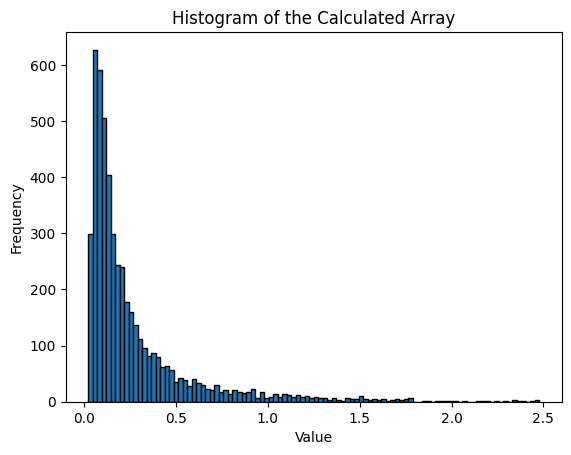

In [ ]:
plt.hist(test_variance, bins=100, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the Calculated Array')
plt.show()

### Calculate Coverage Probability

In [ ]:
def calculate_coverage_probability(y_true, lower_bound, upper_bound):

    # Count how many true values fall within the prediction intervals
    covered = ((y_true >= lower_bound) & (y_true <= upper_bound)).sum()

    # Calculate the coverage probability
    coverage_probability = covered / len(y_true)

    return coverage_probability

# Calculate coverage probability for training data
# train_coverage_probability = calculate_coverage_probability(train_y_original, train_lower_original, train_upper_original)

# Calculate coverage probability for test data
test_coverage_probability = calculate_coverage_probability(test_y_original, test_lower_original, test_upper_original)

# Output the results
# print(f"Training Data Coverage Probability: {train_coverage_probability}")
print(f"Test Data Coverage Probability: {test_coverage_probability}")

Test Data Coverage Probability: 1.0


### Calculate RMSE and Standard Error of model on training and testing data

In [ ]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Function to calculate Standard Error
def standard_error(y_true, y_pred):
    std_dev = np.std(y_true - y_pred)
    return std_dev / np.sqrt(len(y_true))

def calculate_nlpd(predicted_mean, predicted_var, actual_y):

    # Calculate the Gaussian PDF value for each test point
    pdf_values = 1 / np.sqrt(2 * np.pi * predicted_var) * np.exp(-0.5 * (actual_y - predicted_mean)**2 / predicted_var)

    # Calculate the Negative Log-Predictive Density (NLPD)
    nlpd = -np.mean(np.log(pdf_values))

    return nlpd


# Calculate RMSE and NLPD for training data
# train_rmse = rmse(train_y_original, train_mean_original)
# train_se = standard_error(train_y_original, train_mean_original)
# train_nlpd = calculate_nlpd(train_mean_original,train_variance_original, train_y_original)

# Calculate RMSE and NLPD for test data
test_rmse = rmse(test_y_original, test_mean_original)
# test_se = standard_error(test_y_original, test_mean_original)
test_nlpd = calculate_nlpd(test_mean_original, test_variance_original , test_y_original)

In [ ]:
print('Test RMSE: ', test_rmse)
print('Test NLPD: ', test_nlpd)

Test RMSE:  59.40592741192081
Test NLPD:  5.899391693590912


### Making Plots

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

def update_plot(x_range):
    # Initialize plot with larger figure size for clarity
    f, ax = plt.subplots(1, 1, figsize=(18, 8))

    # Set x-axis range to focus on test data only
    start, end = x_range
    ax.set_xlim(start, end)

    # Plot test data as a red line
    ax.plot(range(len(test_y_original)), test_y_original, color='red', label="True Value", linewidth=0.5)

    # Plot predicted line for test data as a blue line
    ax.plot(range(len(test_mean_original)), test_mean_original, color='blue', label="Predicted Value", linewidth=0.5)

    # Plot confidence interval for test data with lighter shade of blue
    ax.fill_between(range(len(test_lower_original)), test_lower_original, test_upper_original, alpha=0.2, color='grey', label="95% Confidence Interval")

    # Adjusting labels, titles, and legend with larger font sizes
    ax.set_xlabel("Time (10-min Intervals)", fontsize=30, labelpad=20)
    ax.set_ylabel("Power Output (kW)", fontsize=30, labelpad=20)
    ax.legend(fontsize=25, loc='upper left')

    # # Annotate RMSE and Standard Error for testing with larger font
    # ax.annotate(f'Test RMSE: {test_rmse:.4f}', xy=(0.5, 0.8), xycoords='axes fraction', fontsize=20)
    # ax.annotate(f'Test NLPD: {test_nlpd:.4f}', xy=(0.5, 0.70), xycoords='axes fraction', fontsize=20)

    ax.tick_params(axis='both', which='major', labelsize=20)

    # Show plot
    plt.show()

# Create the slider for x-axis range, adjusted to test set size
x_max = len(test_y_original)  # Adjust for test set size only
x_slider = widgets.IntRangeSlider(
    value=[0, x_max],
    min=0,
    max=x_max,
    step=1,
    description='X-axis Range:',
    continuous_update=False,
    style={'description_width': 'initial'}  # Ensure the description doesn't get cut off
)

# Show the interactive plot with adjusted x-axis range for test set only
interact(update_plot, x_range=x_slider)

interactive(children=(IntRangeSlider(value=(0, 5040), continuous_update=False, description='X-axis Range:', ma…

<function __main__.update_plot(x_range)>